# Libraries

In [81]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import dask.dataframe as dd

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

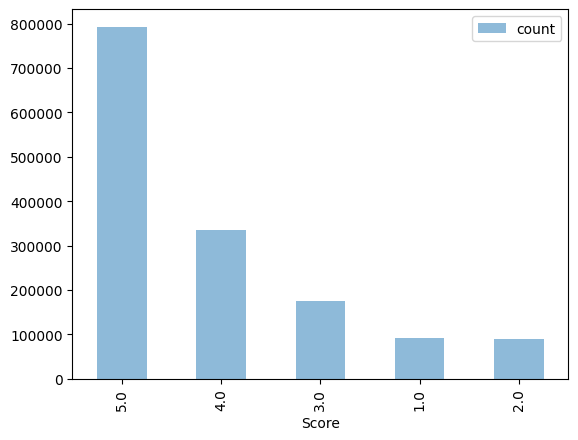


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [82]:
trainingSet = dd.read_csv("train.csv").compute()
testingSet = dd.read_csv("test.csv").compute()

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [84]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from textblob import TextBlob

def add_features_to(df, include_sentiment=True):
    # Handle missing values in 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0)
        df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(1)  # Avoid division by zero
        df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
        df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])

    # Handle missing values in the 'Text' column
    df['Text'] = df['Text'].fillna('')

    # Vectorized ReviewWordCount and ReviewCharCount
    df['ReviewWordCount'] = df['Text'].str.split().str.len()
    df['ReviewCharCount'] = df['Text'].str.len()

    # Optional Sentiment Analysis Features
    if include_sentiment:
        def get_sentiment(text):
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity

        df[['Polarity', 'Subjectivity']] = df['Text'].apply(lambda x: pd.Series(get_sentiment(x)))

    # Additional Length and Uniqueness Features
    df['AvgWordLength'] = df['ReviewCharCount'] / df['ReviewWordCount']
    df['UniqueWordCount'] = df['Text'].str.split().apply(set).str.len()
    df['UniqueWordRatio'] = df['UniqueWordCount'] / df['ReviewWordCount']

    # Helpfulness Flag
    df['IsHelpful'] = (df['HelpfulnessRatio'] >= 0.5).astype(int)

    # Grouped Statistics for Product and Reviewer
    if 'ProductId' in df.columns and 'Score' in df.columns:
        product_stats = df.groupby('ProductId')['Score'].agg(
            ProductAvgRating='mean', ProductReviewCount='count'
        )
        df = df.merge(product_stats, on='ProductId', how='left')

    if 'UserId' in df.columns and 'Score' in df.columns:
        reviewer_stats = df.groupby('UserId')['Score'].agg(
            ReviewerAvgRating='mean', ReviewerReviewCount='count'
        )
        df = df.merge(reviewer_stats, on='UserId', how='left')

    # Normalize Numeric Metadata Features
    numeric_features = [
        'HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount', 'AvgWordLength', 
        'UniqueWordRatio', 'Polarity', 'Subjectivity', 'ProductAvgRating', 
        'ProductReviewCount', 'ReviewerAvgRating', 'ReviewerReviewCount'
    ]
    
    # Check if numeric features exist before scaling
    available_features = [feat for feat in numeric_features if feat in df.columns]
    scaler = StandardScaler()
    df[available_features] = scaler.fit_transform(df[available_features].fillna(0))

    # Drop unused columns
    df = df.drop(['Time', 'Summary'], axis=1, errors='ignore')
    
    return df

In [100]:
# Load the feature extracted files if they've already been generated
if exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
if exists('X_submission.csv'):
    X_submission = pd.read_csv("X_submission.csv")

else:
    # Step 1: Apply feature engineering to the entire trainingSet
    full_train_with_features = add_features_to(trainingSet)

    # Step 2: Sample 20% from the engineered full_train_with_features to create X_train
    sampled_trainingSet = full_train_with_features.sample(frac=0.20, random_state=42)
    X_train = sampled_trainingSet  # This is used for model training

    # Step 3: Create X_submission by merging with testingSet on 'Id'
    X_submission = pd.merge(full_train_with_features, testingSet, left_on='Id', right_on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'], errors='ignore').rename(columns={'Score_y': 'Score'})

    # Step 4: Save processed X_train and X_submission for future use
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

# Data Processing-- Model Building

TF-IDF Vectorization

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def TFIDF_Vectorization(df):
    df['Text'] = df['Text'].fillna('')
    # Create TF-IDF vectorizer and fit it on the entire dataset
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, max_df=0.7)
    # Fit the vectorizer on the 'Text' column to capture the vocabulary and transform the text
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
    print("TF-IDF vectorizer fitting completed!")
    return tfidf_matrix

def svd(matrix):
    # Apply Truncated SVD to reduce the dimensionality of the TF-IDF matrix
    n_components = 100  # You can adjust this number as needed
    svd = TruncatedSVD(n_components=n_components, random_state=42)  
    reduced = svd.fit_transform(matrix)
    print(f"Dimensionality reduced to {n_components} components using Truncated SVD.")
    return reduced

In [102]:
# Step 1: Generate the TF-IDF matrix and apply SVD
tfidf_matrix = TFIDF_Vectorization(X_train)
tfidf_reduced = svd(tfidf_matrix)

# Step 2: Convert the reduced TF-IDF matrix to a DataFrame
tfidf_features = [f'TFIDF_{i}' for i in range(tfidf_reduced.shape[1])]  # Create column names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=tfidf_features, index=X_train.index)

# Step 3: Concatenate the reduced TF-IDF features back into X_train
X_train = pd.concat([X_train.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Now X_train includes the vectorized text columns as TF-IDF features
print("X_train with TF-IDF features:", X_train.head())

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.
X_train with TF-IDF features:         Id   ProductId          UserId  \
0   565351  B000053V8F  A3GAGA790C3F90   
1   450021  6305126062  A2U9M4SE42KFK8   
2  1124790  B00105308I  A1AISPOIIHTHXX   
3  1521546  B006WQUL64  A2435XASRUN5O0   
4   749431  B00008YGRS  A3I7UACA67A3NP   

                                                Text  Score  HelpfulnessRatio  \
0  While this follows the book much more closely ...    3.0         -0.953032   
1  Great story on how issues can be over come wit...    NaN         -0.953032   
2  Despite the fact that South Park has maintaine...    4.0         -0.953032   
3  If you love Bogey, you'll be well entertained ...    NaN          1.431414   
4  Can I get my half hour back? Can I get my half...    NaN         -0.953032   

   ReviewWordCount  ReviewCharCount  Polarity  Subjectivity  ...  TFIDF_90  \
0        -0.566694        -0.565026 -0.195982     -0.

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Define Metadata Features to Include
numeric_metadata_features = ['HelpfulnessRatio', 'ReviewWordCount', 'ProductAvgRating', 
                             'ProductReviewCount', 'ReviewerReviewCount', 
                             'ReviewerAvgRating', 'Polarity', 'Subjectivity']

# Step 2: Normalize the Numeric Metadata Features
scaler = StandardScaler()
normalized_numeric_metadata = scaler.fit_transform(full_train_with_features[numeric_metadata_features])
normalized_numeric_metadata_df = pd.DataFrame(normalized_numeric_metadata, columns=numeric_metadata_features)

# Step 3: Convert TF-IDF Reduced Matrix to DataFrame with Column Names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=[f"TFIDF_{i}" for i in range(tfidf_reduced.shape[1])])

# Step 4: Combine Reduced TF-IDF with Metadata Features
X_combined = pd.concat([normalized_numeric_metadata_df.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Step 5: Define the Target Variable
y = full_train_with_features['Score'].fillna(full_train_with_features['Score'].median())  # Handle missing values in the target

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Confirm Completion
print("Feature selection and train-test split completed!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Feature selection and train-test split completed!
X_train shape: (1273149, 108)
X_test shape: (424384, 108)
y_train shape: (1273149,)
y_test shape: (424384,)


# Model Creation

In [105]:
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in Y_train:", y_train.isnull().sum())
print("Data types in X_train:\n", X_train.dtypes)
print("Data type in Y_train:",y_train.dtype)

Missing values in X_train: 101811000
Missing values in Y_train: 0
Data types in X_train:
 HelpfulnessRatio       float64
ReviewWordCount        float64
ProductAvgRating       float64
ProductReviewCount     float64
ReviewerReviewCount    float64
                        ...   
TFIDF_95               float64
TFIDF_96               float64
TFIDF_97               float64
TFIDF_98               float64
TFIDF_99               float64
Length: 108, dtype: object
Data type in Y_train: float64


In [143]:
X_train.columns

Index(['HelpfulnessRatio', 'ReviewWordCount', 'ProductAvgRating',
       'ProductReviewCount', 'ReviewerReviewCount', 'ReviewerAvgRating',
       'Polarity', 'Subjectivity', 'TFIDF_0', 'TFIDF_1',
       ...
       'TFIDF_90', 'TFIDF_91', 'TFIDF_92', 'TFIDF_93', 'TFIDF_94', 'TFIDF_95',
       'TFIDF_96', 'TFIDF_97', 'TFIDF_98', 'TFIDF_99'],
      dtype='object', length=108)

In [108]:
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Predict the scores on the test data
y_test_pred = xgb_model.predict(X_test)

print("XGBoost Model Training and Prediction Completed!")

XGBoost Model Training and Prediction Completed!


In [109]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
}

random_search = RandomizedSearchCV(xgb_model, param_distributions, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [114]:
model = best_xgb_model

# Make predictions with the best model
y_test_pred = model.predict(X_test)

# Round the predictions to the nearest integer
y_test_pred = np.round(y_test_pred).astype(int)

# Clip predictions to ensure they are within the 1-5 range
y_test_pred = np.clip(y_test_pred, 1, 5)

# Model Evaluation

Accuracy on testing set =  0.5648634255768361


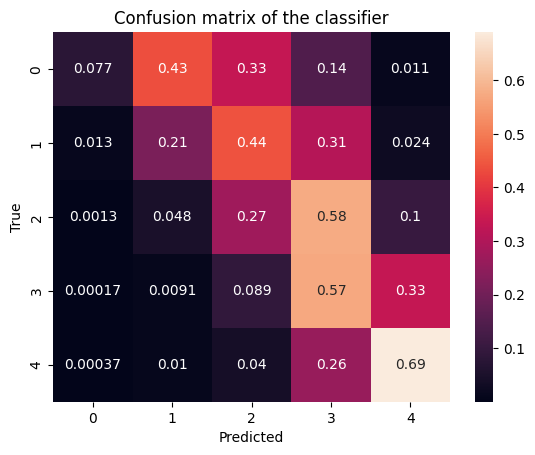

In [115]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(y_test, y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [122]:
X_submission.columns

Index(['Id', 'ProductId', 'UserId', 'Text', 'HelpfulnessRatio',
       'ReviewWordCount', 'ReviewCharCount', 'Polarity', 'Subjectivity',
       'AvgWordLength', 'UniqueWordCount', 'UniqueWordRatio', 'IsHelpful',
       'ProductAvgRating', 'ProductReviewCount', 'ReviewerAvgRating',
       'ReviewerReviewCount', 'Score'],
      dtype='object')

# Create submission file

In [145]:
# TF-IDF X_submission
# Step 1: Generate the TF-IDF matrix and apply SVD
tfidf_matrix = TFIDF_Vectorization(X_submission)
tfidf_reduced = svd(tfidf_matrix)

# Step 2: Convert the reduced TF-IDF matrix to a DataFrame
tfidf_features = [f'TFIDF_{i}' for i in range(tfidf_reduced.shape[1])]  # Create column names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=tfidf_features, index=X_submission.index)

# Step 3: Concatenate the reduced TF-IDF features back into X_train
X_submission_select = pd.concat([X_submission.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Now X_train includes the vectorized text columns as TF-IDF features
print("X_submission with TF-IDF features:", X_submission.head())

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.
X_submission with TF-IDF features:         Id   ProductId          UserId  \
0  1323432  B0034G4P30  A120UTHQDQIJGH   
1  1137299  B0012IWO0I  A3SJBFCTJWBFT2   
2  1459366  B005FUTBSC  A1V6FRU7EXP6N9   
3   931601  B000AREXBU   ARXDDR76Z5Q2I   
4  1311995  B002ZG99B8   A2XAS9GVZL3B1   

                                                Text  HelpfulnessRatio  \
0  This movie was just alright for me. I think pe...         -0.953032   
1  My kids love this movie.  Exciting and fun to ...          1.431414   
2  The effects were good, not the best but far fr...         -0.953032   
3  I just got a copy of this S. Korean dvd of "He...          1.431414   
4  OK, to put this clearly and bluntly... if you ...          1.431414   

   ReviewWordCount  ReviewCharCount  Polarity  Subjectivity  AvgWordLength  \
0        -0.012424        -0.071850  0.473931     -0.265934      -0.636209   
1        -0.

In [149]:
features = X_test.columns

X_submission_select = X_submission[features]

In [153]:
# Create the submission file with discrete scores
X_submission['Score'] = model.predict(X_submission_select)

# Round the predictions to the nearest integer and clip them to the valid score range (e.g., 1 to 5)
X_submission['Score'] = X_submission['Score'].round().clip(1, 5).astype(int)

# Prepare the final submission DataFrame
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)